In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable

In [2]:
# usa markets
stocks = ["aapl", "msft", "wmt", "tsla", "nvda", "c", "ko",  'amzn',
          'meli', 'googl', 'meta', 'gm', 'orcl', 'amd', "brk-b", "txn", 'nflx',
          'ggal', 'irs', 'bma', 'ypf', 'supv', "pam", "tx", "cresy", "tgs",]

In [3]:
def calculate_cagr(initial_value, final_value, weeks_held):
    # Convert weeks to years
    years_held = weeks_held / 52
    # Calculate CAGR
    if (years_held == 0):
        return 0
    cagr = (final_value / initial_value) ** (1 / years_held) - 1
    return cagr

In [4]:
def yield_function(w1_fast, w2_medium, w3_slow, df):
    df['slow'] = df['close'].rolling(w3_slow).mean()
    df['medium'] = df['close'].rolling(w2_medium).mean()
    df['fast'] = df['close'].rolling(w1_fast).mean()
    df = df.dropna()

    close = df['close'].to_numpy()
    slow = df['slow'].to_numpy()
    medium = df['medium'].to_numpy()
    fast = df['fast'].to_numpy()

    it = np.nditer(slow, flags=['f_index'])

    bought = False
    cost = 0
    cost_week = 0
    total_yield = 1
    total_weeks = 0
    transactions = 0
    positive_transactions = 0

    for k in it:
        i = it.index
        slow_v = slow[i]
        medium_v = medium[i]
        fast_v = fast[i]
        close_v = close[i]

        if (not bought):
            if (fast_v > medium_v and fast_v > slow_v and medium_v > slow_v):
                bought = True
                transactions += 1
                cost = close_v
                cost_week = i
                continue
        if (bought):
            criterium = fast_v < medium_v and fast_v < slow_v and medium_v < slow_v
            if (criterium):
                profit = ((close_v/cost)-1)
                if profit > 0:
                    positive_transactions += 1
                bought = False
                total_yield += total_yield*profit
                total_weeks += (i-cost_week)
    final_cagr = calculate_cagr(1, total_yield, total_weeks) * 100
    if (transactions == 0):
        return -final_cagr, 0
    return -final_cagr, (positive_transactions/transactions)


def obj_func_wrapper(params, *args):
    [w1_fast, w2_medium, w3_slow] = params
    w3_slow = int(w3_slow)
    w2_medium = int(w2_medium)
    w1_fast = int(w1_fast)
    df = args[0]
    cagr, _ = yield_function(w1_fast, w2_medium, w3_slow, df)
    return cagr

In [5]:
results_de = {}
for stock in stocks:
    df = pd.read_csv(f'data/{stock}_quote_data.csv')
    bounds = [(5, 15), (20, 35), (40, 60)]
    x0 = np.array([10, 30, 50])
    result = sp.optimize.differential_evolution(
        obj_func_wrapper, bounds, integrality=[True, True, True], args=(df, 1), x0=x0)
    fast = int(result.x[0])
    medium = int(result.x[1])
    slow = int(result.x[2])
    _, profitability = yield_function(fast, medium, slow, df)
    results_de[stock] = {"result": -result.fun, 'fast': fast, "medium": medium,
                         "slow": slow, "profitability": profitability}

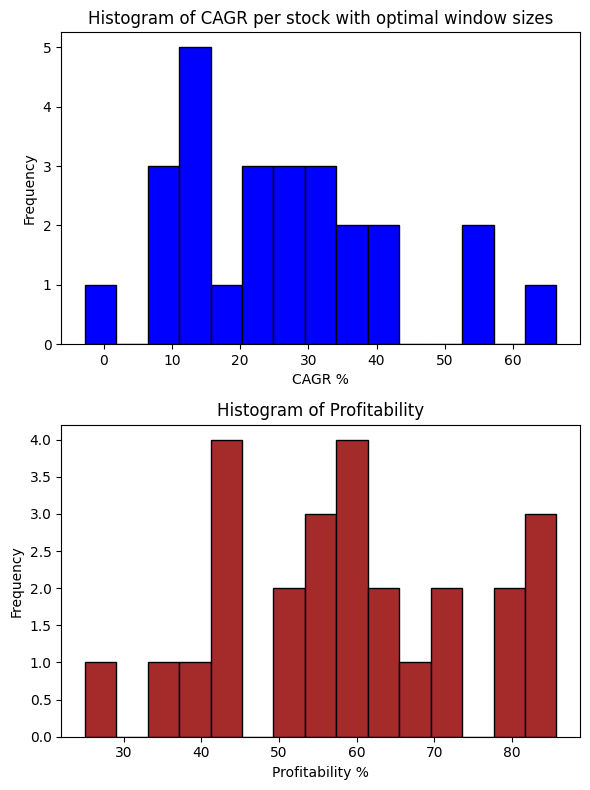

In [6]:
res_arr = [val['result'] for val in results_de.values()]
fast_arr = [val['fast'] for val in results_de.values()]
medium_arr = [val['medium'] for val in results_de.values()]
slow_arr = [val['slow'] for val in results_de.values()]
prof_arr = [val['profitability']*100 for val in results_de.values()]

# Create a figure and 3 subplots
fig, axs = plt.subplots(2, 1, figsize=(6, 8))

# Plot the histograms
axs[0].hist(res_arr, bins=15, color='blue', edgecolor='black')
axs[0].set_title('Histogram of CAGR per stock with optimal window sizes')
axs[0].set_xlabel('CAGR %')
axs[0].set_ylabel('Frequency')

axs[1].hist(prof_arr, bins=15, color='brown', edgecolor='black')
axs[1].set_title('Histogram of Profitability')
axs[1].set_xlabel('Profitability %')
axs[1].set_ylabel('Frequency')

# axs[2].hist(fast_arr, bins=15, color='yellow', edgecolor='black')
# axs[2].set_title('Histogram of Fast Window Sizes')
# axs[2].set_xlabel('Fast Window Size')
# axs[2].set_ylabel('Frequency')

# axs[3].hist(medium_arr, bins=15, color='green', edgecolor='black')
# axs[3].set_title('Histogram of Medium Window Sizes')
# axs[3].set_xlabel('Medium Window Size')
# axs[3].set_ylabel('Frequency')

# axs[4].hist(slow_arr, bins=15, color='red', edgecolor='black')
# axs[4].set_title('Histogram of Slow Window Sizes')
# axs[4].set_xlabel('Slow Window Size')
# axs[4].set_ylabel('Frequency')


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [7]:
table = PrettyTable()
table.field_names = ["Ticker", "DE fast", "DE medium",
                     "DE slow", "DE CAGR %", 'DE profitability %']

for ticker, value in results_de.items():
    table.add_row([ticker, value['fast'], value["medium"], value["slow"],
                  round(value["result"], 2), round(value['profitability']*100, 2)])

print(table)

+--------+---------+-----------+---------+-----------+--------------------+
| Ticker | DE fast | DE medium | DE slow | DE CAGR % | DE profitability % |
+--------+---------+-----------+---------+-----------+--------------------+
|  aapl  |    14   |     25    |    52   |   25.04   |       56.25        |
|  msft  |    15   |     29    |    42   |   31.31   |       58.82        |
|  wmt   |    6    |     25    |    45   |   23.06   |       59.09        |
|  tsla  |    12   |     35    |    59   |   66.37   |       85.71        |
|  nvda  |    8    |     20    |    40   |   40.42   |        50.0        |
|   c    |    15   |     34    |    47   |   10.91   |        40.0        |
|   ko   |    10   |     31    |    40   |   13.41   |       45.16        |
|  amzn  |    12   |     21    |    51   |   53.21   |       77.78        |
|  meli  |    15   |     34    |    40   |   41.94   |       57.14        |
| googl  |    15   |     23    |    50   |   21.43   |       85.71        |
|  meta  |  

# New approach - Stop Loss


In [8]:
def yield_function_sl(w1_fast, w2_medium, w3_slow, df, stop_loss):
    df['slow'] = df['close'].rolling(w3_slow).mean()
    df['medium'] = df['close'].rolling(w2_medium).mean()
    df['fast'] = df['close'].rolling(w1_fast).mean()
    df = df.dropna()

    close = df['close'].to_numpy()
    slow = df['slow'].to_numpy()
    medium = df['medium'].to_numpy()
    fast = df['fast'].to_numpy()

    it = np.nditer(slow, flags=['f_index'])

    bought = False
    cost = 0
    cost_week = 0
    total_yield = 1
    total_weeks = 0
    transactions = 0
    positive_transactions = 0
    profitability = 0

    for k in it:
        i = it.index
        slow_v = slow[i]
        medium_v = medium[i]
        fast_v = fast[i]
        close_v = close[i]

        if (not bought):
            if (fast_v > medium_v and fast_v > slow_v and medium_v > slow_v):
                transactions += 1
                bought = True
                cost = close_v
                cost_week = i
                continue
        if (bought):
            this_profit = ((close_v/cost)-1)
            sell_criterium = fast_v < medium_v and fast_v < slow_v and medium_v < slow_v
            if sell_criterium or (this_profit < stop_loss):
                bought = False
                if this_profit > 0:
                    positive_transactions += 1
                total_yield += total_yield*this_profit
                total_weeks += (i-cost_week)
    final_cagr = calculate_cagr(1, total_yield, total_weeks) * 100
    if transactions > 0:
        profitability = positive_transactions / transactions
    return -final_cagr, profitability


def obj_func_wapper(params, *args):
    [w1_fast, w2_medium, w3_slow] = params
    w3_slow = int(w3_slow)
    w2_medium = int(w2_medium)
    w1_fast = int(w1_fast)
    df = args[0]
    stop_loss = args[1]
    cagr, _ = yield_function_sl(w1_fast, w2_medium, w3_slow, df, stop_loss)
    return cagr

In [9]:
results_de_sl = {}
for stock in stocks:
    df = pd.read_csv(f'data/{stock}_quote_data.csv')
    bounds = [(5, 15), (20, 35), (40, 60)]
    x0 = np.array([10, 30, 50])
    stop_loss = 0.1
    result = sp.optimize.differential_evolution(
        obj_func_wapper, bounds, integrality=[True, True, True], args=(df, stop_loss), x0=x0)
    fast = int(result.x[0])
    medium = int(result.x[1])
    slow = int(result.x[2])
    _, profitability = yield_function_sl(fast, medium, slow, df, stop_loss)
    results_de_sl[stock] = {"result": -result.fun, 'fast': fast, "medium": medium,
                            "slow": slow, "profitability": profitability}

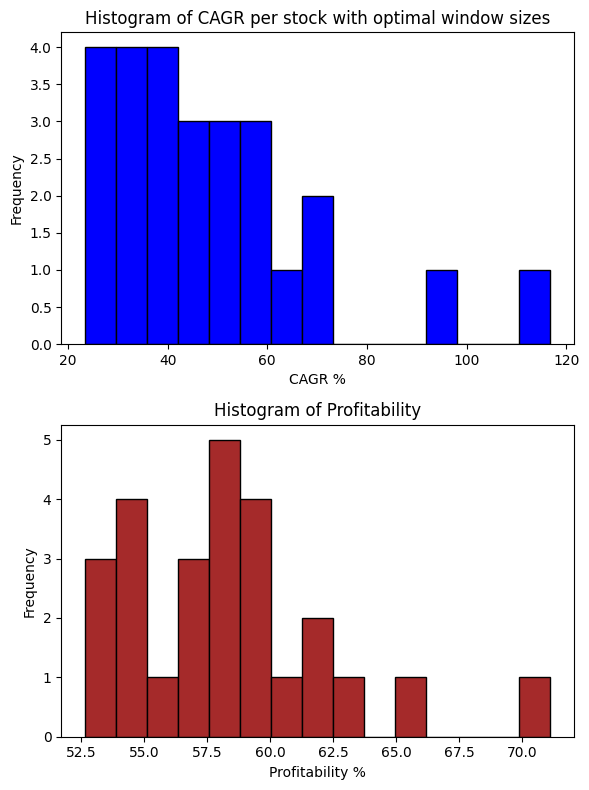

In [10]:
res_arr = [val['result'] for val in results_de_sl.values()]
prof_arr = [val['profitability']*100 for val in results_de_sl.values()]

# Create a figure and 3 subplots
fig, axs = plt.subplots(2, 1, figsize=(6, 8))

# Plot the histograms
axs[0].hist(res_arr, bins=15, color='blue', edgecolor='black')
axs[0].set_title('Histogram of CAGR per stock with optimal window sizes')
axs[0].set_xlabel('CAGR %')
axs[0].set_ylabel('Frequency')

axs[1].hist(prof_arr, bins=15, color='brown', edgecolor='black')
axs[1].set_title('Histogram of Profitability')
axs[1].set_xlabel('Profitability %')
axs[1].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [11]:
table = PrettyTable()
table.field_names = ["Ticker", "DE SL fast", "DE SL medium",
                     "DE SL slow", "DE SL CAGR %", 'DE SL profitability %']

for ticker, value in results_de_sl.items():
    table.add_row([ticker, value['fast'], value["medium"], value["slow"],
                  round(value["result"], 2), round(value['profitability']*100, 2)])

print(table)

+--------+------------+--------------+------------+--------------+-----------------------+
| Ticker | DE SL fast | DE SL medium | DE SL slow | DE SL CAGR % | DE SL profitability % |
+--------+------------+--------------+------------+--------------+-----------------------+
|  aapl  |     7      |      22      |     43     |    49.36     |         62.25         |
|  msft  |     11     |      33      |     42     |    47.09     |         57.93         |
|  wmt   |     6      |      27      |     43     |    36.74     |          54.0         |
|  tsla  |     8      |      32      |     59     |    116.81    |         65.22         |
|  nvda  |     9      |      22      |     47     |     54.5     |         54.75         |
|   c    |     9      |      25      |     58     |    25.85     |         56.99         |
|   ko   |     7      |      32      |     45     |    23.33     |         56.74         |
|  amzn  |     5      |      21      |     41     |    71.36     |         60.76         |